In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import collections

In [6]:
class El_Farol_env:
    def __init__(self, NUM_AGENTS = 100, M = 5, N = 20, THR = 60, SEED=42):
        np.random.seed(SEED)
        self. num_agents = NUM_AGENTS # Number of agents
        self.M = M # Number of weeks to remember (memory)
        self.N = N # Number of strategies per agent
        self.THR = THR # Occupancy threshold
        
        # Initialize random decision weights for all players
        self.weight_mat = np.random.uniform(-1, 1, (self.num_agents, self.N, self.M + 1))
        
        # Initialize 2*M random instances of weeks of attendance
        self.A_M = collections.deque(maxlen = 2*self.M)
        for i in range(2*self.M):
            self.A_M.append(np.random.randint(0, self.num_agents-1))
        
        # Initialize the current time step's attendance: 
        self.A_t = np.random.randint(0, self.num_agents-1)
        
        # Initialize A circular buffer of M Predictions for attendance for each week
        self.S_pred = collections.deque()
    
    def make_decision(self, w_vec, A_vec, s_ind=None):
        '''
        # Decision making for one agent:
        # Inputs:
        #       w_vec: [N x M+1] - Initialized weight vectors (and bias) for one agent's strategies 
        #       A_vec: [2M x 1] - Attendance for the last M steps (Cirular buffer)
        #       s_ind: Index {0,N} of the previous best decision strategy, if None, estimate based on memory
        # Outputs:
        #       d: [0, 1] ~ [DON'T GO, GO]
        #       S_guess: Scalar - Estimated number of attendees for current time step (mostly used for troubleshooting)
        '''
        S = np.zeros((self.N, self.M+1))
        E = np.zeros(self.N)
        
        for i in range(self.N):
            for j in range(self.M+1):
                S[i,j] = 100 * (np.dot(w_vec[i,:-1], np.array(A_vec)[self.M-j:2*self.M-j]) + w_vec[i,-1])
        
#         print(S[0,1:].shape)
#         print(np.array(A_vec)[self.M:].shape)
        # Calculating the errors:
        for i in range(self.N):
            E[i] = np.abs(S[i,1:] - np.array(A_vec)[self.M:]).sum() # Don't know A_t, so S[i,0] error can't be calculated yet
        
        # Making the decision:
        if s_ind is None: # Initial time step
            # Select the strategy with the smallest error:
            s_ind = np.argmin(E)
            
        S_guess = S[s_ind, 0] # Select the estimate (j=0) for current step
        
        # Make Decision:
        if S_guess <= self.THR: 
            d = 1 # GO
        else: 
            d = 0 # DON'T GO
    
        return d, S_guess
         
    
    def update_s_star(self, w_vec, A_vec, A_t):
        '''
        # Decision making for one agent:
        # Inputs:
        #       w_vec: [N x M+1] - Initialized weight vectors (and bias) for one agent's strategies 
        #       A_vec: [M x 1] - Attendance for the last M steps (Cirular buffer)
        #       A_t: Current time step's attendance
        # Outputs:
        #       s_ind: Scalar integer: New optimum strategy for the agent
        #       S_guess: New estimated number of attendees (mostly used for troubleshooting)
        '''
        S = np.zeros((self.N, self.M+1))
        E = np.zeros(self.N)
        
        for i in range(self.N):
            for j in range(self.M+1):
                S[i,j] = 100 * (np.dot(w_vec[i,:-1], np.array(A_vec)[self.M-j:2*self.M-j]) + w_vec[i,-1])
                
        for i in range(self.N):
            E[i] = np.abs(S[i,1:] - np.array(A_vec)[self.M:]).sum() # Don't know A_t, so S[i,0] error can't be calculated yet
            # Add the error for the current step:
            E[i] += np.abs(S[i,0] - A_t)
        
        s_ind = np.argmin(E).astype(int)
        S_guess = S[s_ind]
        
        return s_ind, S_guess
        
        
    def take_steps(self, num_steps=100):
        '''
        # Simulate multiple weeks of events and decisions
        # Inputs:
        #       num_steps: Scalar integer - number of weeks to simulate
        '''
        s_star = np.zeros((self.num_agents, 1)).astype(int)
        S_guessed = np.zeros((self.num_agents, 1))
        agents_performance = np.zeros((self.num_agents, 1))
        A_ts = np.zeros((num_steps, 1)) # Actual number of attendees
        d = np.zeros((self.num_agents, 1))
        
        # Iterating for desired number of steps:
        for step_i in range(num_steps):
            # Iterating for each agent:
            for agent_j in range(self.num_agents):
                w_vec = self.weight_mat[agent_j,:,:]
                A_vec = self.A_M
                if step_i == 0: # Initial step 
                    s_ind = None
                else:
                    s_ind = s_star[agent_j]
                # Make decision:
                d[agent_j], S_guessed[agent_j] = self.make_decision(w_vec=w_vec, A_vec=A_vec, s_ind=s_ind)
            
            # Calculate A_t
            A_t = np.sum(d) # Number of agents who decided to go
            A_ts[step_i] = A_t
            
            # Update circular A_M buffer:
            self.A_M.append(A_t)
            
            # Update S_star for each agent - based on observed A_t
            for agent_j in range(self.num_agents):
                w_vec = self.weight_mat[agent_j,:,:]
                A_vec = self.A_M
                s_star[agent_j], _ = self.update_s_star(w_vec=w_vec, A_vec=A_vec, A_t=A_t)
                # Estimate performance of each agent
                if (S_guessed[agent_j] <= self.THR) and (d[agent_j] == 1): # Correct decision was made
                    agents_performance[agent_j] += 1
                    
        # What do we want the function to retun?
        return A_ts, agents_performance

In [26]:
# Testing the full environment:
env = El_Farol_env(NUM_AGENTS=100, M=5, N=10, THR = 60, SEED=42)
A_ts, agents_performance = env.take_steps(num_steps=100)

In [27]:
agents_performance.mean()

28.2

In [28]:
A_ts.mean()

47.0

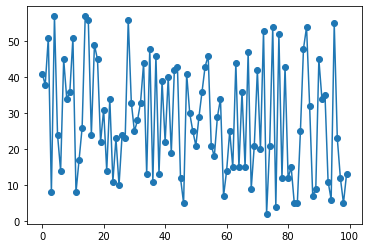

In [30]:
# plt.plot(A_ts, '-o')
plt.plot(agents_performance, '-o')

In [ ]:
# Debugging #2:
env = El_Farol_env(NUM_AGENTS=100, M=3, N=2, THR = 60, SEED=42)
w_vec = env.weight_mat[1,:,:]
A_vec = env.A_M
M = 3
N = 2
S, E, d, S_guess = env.make_decision(w_vec=w_vec, A_vec=A_vec, s_ind=None)

print(S)
print(E)
print(S_guess)
print(d)

In [ ]:
# Debugging #1:
env = El_Farol_env(NUM_AGENTS=100, M=3, N=2, THR = 60, SEED=42)

w_vec = env.weight_mat[1,:,:]
A_vec = env.A_M

S = np.zeros(env.N)
E = np.zeros(env.N)
for i in range(env.N):
    S[i] = 100 * (np.dot(w_vec[i,:-1], A_vec) + w_vec[i,-1])
    E[i] = (np.abs(S[i] - np.array(A_vec))).sum()

print('W: ', w_vec)
print('A:', A_vec)
print('S:', S)
print('E:', E)

# print(env.weight_mat.shape)
# print(env.weight_mat[0,:,:].shape)
# print(np.squeeze(env.weight_mat[3,:,:]).shape)
# print("wvec [agent_0] = ", np.squeeze(env.weight_mat[0,:,:]))